In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

# Setup and Cleaning

In [2]:
teamNames = ['Phoenix','Orlando','Washington','Detroit','Indiana','Atlanta',
            'Toronto','Miami','Charlotte','Brooklyn','Cleveland','Memphis','Minnesota',
            'Chicago','New Orleans','Dallas','Denver','San Antonio','Sacramento','L.A. Clippers',
            'L.A. Lakers','Philadelphia','Boston', 'New York','Houston','Oklahoma City',
            'Golden State','Utah','Portland','Milwaukee','Baltimore']

In [3]:
# four months for each
f1 = pd.read_csv('./Data Files/1_oct_2018_jan_2019.csv')
f2 = pd.read_csv('./Data Files/2_feb_2018_may_2018.csv')
f3 = pd.read_csv('./Data Files/3_oct_2017_dec_2017.csv')
f4 = pd.read_csv('./Data Files/4_apr_2017_jun_2017.csv')
f5 = pd.read_csv('./Data Files/5_nov_2016_feb_2017.csv')

# 5 years for each
f6 = pd.read_csv('./Data Files/apr_2014_may_2016.csv')
f7 = pd.read_csv('./Data Files/apr_2009_mar_2014.csv')

/home/richie10181/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,7,11,15,19,23,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# append the separate dfs
data = f1.append(f2)
data = data.append(f3)
data = data.append(f4)
data = data.append(f5)
data = data.append(f6)
data = data.append(f7)

In [5]:
# make sure each row has a date, teams, and points
include = data['Date'].notnull() & data['Teams'].notnull() & data['Points'].notnull()

In [6]:
# filter data to remove issues
data = data[include]

In [7]:
# fill NaN values with dash so they are not counted in odds calculation
data = data.fillna(value='-')

# remove unnamed column
data = data.drop('Unnamed: 0', axis=1)

## Important Inputs

In [62]:
# minimum number of bookies supplying odds. fewer odds than the number below will be excluded
min_number_odds = 12

# how many outliers to remove (i.e. 2 means remove highest 2 and lowest 2 odds supplied)
num_outliers = 3

In [63]:
avg_odds_l = []
avg_prob_l = []
max_odds_l = []
max_prob_l = []

for i in range(len(data)):
    
    # sort odds in each row
    sl = np.sort([int(x) for x in data.iloc[i,7:34].values if x != '-'])[::-1]

    # remove top 2 and bottom 2 values (avoid outliers and data issues)
    sl_sub = sl[num_outliers:len(sl)-num_outliers]

    # calculate average odds of 24 remaining bookies
    # only append new odds/probs if x bookies give odds
    if len(sl_sub) > min_number_odds:
        avg_odds = np.mean(sl_sub)
        max_odds = np.max(sl_sub)
        
        if max(sl_sub) - min(sl_sub) < 275:
            probs_tmp = []
            for odds in sl_sub:
                # calculate implied probabilities using odds
                if int(odds) > 0:
                    probs_tmp.append(1/(1 + int(odds)/100))
                else:
                    probs_tmp.append((-int(odds)/100)/(1-int(odds)/100))

            # calculate max prob
            if int(max_odds) > 0:
                max_prob_l.append(1/(1 + int(max_odds)/100))
            else:
                max_prob_l.append((-int(max_odds)/100)/(1-int(max_odds)/100))

            avg_odds_l.append(avg_odds)
            avg_prob_l.append(np.mean(probs_tmp))
            max_odds_l.append(max_odds)
        
        else:
            avg_odds_l.append(0)
            avg_prob_l.append(0)
            max_odds_l.append(0)
            max_prob_l.append(0)

    else:
        avg_odds_l.append(0)
        avg_prob_l.append(0)
        max_odds_l.append(0)
        max_prob_l.append(0)

In [64]:
# append computed odds and probabilities to dataframe
data['Average_Odds'] = avg_odds_l
data['Average_Probs'] = avg_prob_l
data['Max_Odds'] = max_odds_l
data['Max_Implied_Prob'] = max_prob_l

In [65]:
# get rid of random team names in pts column
include_pts1 = [False if data.iloc[i,3] in teamNames else True for i in range(len(data))]
data = data[include_pts1]

In [66]:
include_pts2 = [False if data.iloc[i,3] == '-' else True for i in range(len(data))]
data = data[include_pts2]

In [67]:
# get rid of ridiculous point totals
# these totals occur in same game when team name is stored as other team's point total
include_pts3 = [False if int(data.iloc[i,3]) > 200 or int(data.iloc[i,3]) < 0
                else True for i in range(len(data))]
data = data[include_pts3]

In [68]:
# sometimes only one team was pulled. use gameID to filter for these and throw them out
games_check = []
for i in range(len(data)-1):
    if data.iloc[i,0] == data.iloc[i-1,0] or data.iloc[i,0] == data.iloc[i+1,0]:
        games_check.append(True)
    else:
        games_check.append(False)

In [69]:
# last two teams make up appropriate game, so append a 1
games_check.append(True)

In [70]:
# filter for games
data = data[games_check]

In [71]:
# create column for outcome of game
outcome_arr = [[0,1] if int(data.iloc[i,3]) > int(data.iloc[i-1,3]) else [1,0] for i in range(1,len(data),2)]

In [72]:
# reshape array so shape is compatible with dataframe
outcome_l = [x[0] for x in np.array(outcome_arr).reshape(len(outcome_arr)*2,1)]
data['Outcome'] = outcome_l

In [73]:
# create home/away column and append
home_away_l = ['Home' if i % 2 == 0 else 'Away' for i in range(1,len(data)+1)]
data['Home_Away'] = home_away_l

## Sanity Checks

In [74]:
# make sure all games include 2 teams
test_gameID = [[1,1] if data.iloc[i,0] == data.iloc[i-1,0] else [0,0] for i in range(1,len(data),2)]
test_gameID_l = [x[0] for x in np.array(test_gameID).reshape(len(test_gameID)*2,1)]
print('All gameIDs in pairs?', len(test_gameID_l) == sum(test_gameID_l))

All gameIDs in pairs? True


### insert things here if necessary

In [75]:
# export cleaned data
data.to_csv('./Data Files/cleaned_data.csv', sep=',')

# Analysis

## Binning - All Games and Outcomes (no controlling for win/loss)

### Important Inputs

In [76]:
num_bins = 100

### why not create bins manually so more obsevations in each???

In [77]:
# bin data
bin_count = np.histogram(data['Average_Probs'], bins=num_bins)
bin_count[0]

array([5637,    0,    0,    0,    0,    0,    2,    3,    4,   16,   27,
         44,   40,   39,   51,   58,   48,   32,   51,   64,   88,   86,
         71,   58,   88,   95,   96,   98,   99,  113,  106,  123,   99,
        110,  137,  124,  122,  142,  160,  154,  120,  146,  137,  133,
        113,   94,  103,  113,   84,  100,   86,  109,  102,   93,   53,
         59,  115,  121,  115,  121,  111,  132,  120,  101,  135,  151,
        156,  106,  118,  128,  104,  141,  119,  130,  144,  119,  121,
         96,  114,   86,   98,  108,   85,   86,   74,   62,   62,   86,
         76,   54,   44,   40,   46,   58,   49,   34,   31,   11,    3,
          3])

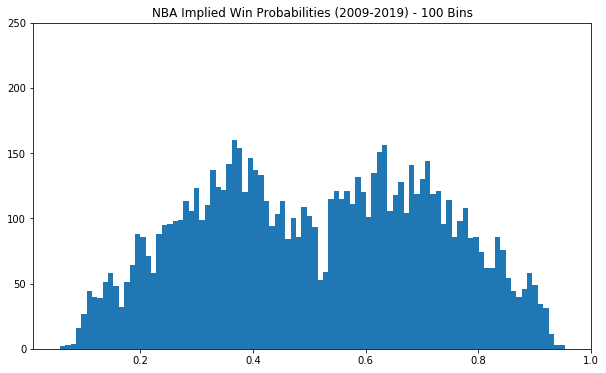

In [78]:
# show all bins except 0 - many discarded due to too few odds available
plt.figure(figsize=(10,6))
plt.hist(data['Average_Probs'], bins=num_bins)
plt.xlim(.01,1)
plt.ylim(0,250)
plt.title('NBA Implied Win Probabilities (2009-2019) - 100 Bins')
plt.show()

In [79]:
# calculate mean probability for each bin
bins = scipy.stats.binned_statistic(data['Average_Probs'],data['Average_Probs'], 
                                    statistic='mean',bins=num_bins)

In [80]:
# shows implied consensus win % based on odds
consensus_mean = bins.statistic
consensus_mean

array([ 0.        ,         nan,         nan,         nan,         nan,
               nan,  0.06408181,  0.07047952,  0.07966451,  0.09052617,
        0.10077356,  0.11018015,  0.12005187,  0.12819958,  0.13833123,
        0.14706071,  0.15776207,  0.16676473,  0.17642566,  0.18619362,
        0.1954977 ,  0.20420113,  0.21447313,  0.22418276,  0.23392748,
        0.24314947,  0.25318317,  0.26198075,  0.27152784,  0.28176829,
        0.29034351,  0.30064898,  0.30972897,  0.31936099,  0.32893362,
        0.33815115,  0.34841639,  0.35694018,  0.36713982,  0.3764597 ,
        0.3854533 ,  0.39547356,  0.40483375,  0.41454021,  0.42349926,
        0.43403757,  0.44295325,  0.45274951,  0.46157957,  0.47213351,
        0.48096201,  0.49073483,  0.50051007,  0.50931523,  0.51903497,
        0.52947381,  0.53816139,  0.54815297,  0.55723785,  0.56666164,
        0.57706732,  0.5859204 ,  0.59586342,  0.60544848,  0.61431854,
        0.62368666,  0.63359757,  0.64315432,  0.65267709,  0.66

In [81]:
bins_actual = scipy.stats.binned_statistic(data['Average_Probs'],data['Outcome'], 
                                    statistic='mean',bins=num_bins)

In [82]:
# shows the actual win % within each bin
actual_mean = bins_actual.statistic
actual_mean

array([ 0.50860387,         nan,         nan,         nan,         nan,
               nan,  0.        ,  0.        ,  0.25      ,  0.0625    ,
        0.22222222,  0.09090909,  0.25      ,  0.07692308,  0.19607843,
        0.0862069 ,  0.16666667,  0.1875    ,  0.21568627,  0.203125  ,
        0.26136364,  0.20930233,  0.22535211,  0.22413793,  0.19318182,
        0.29473684,  0.22916667,  0.24489796,  0.3030303 ,  0.27433628,
        0.26415094,  0.28455285,  0.27272727,  0.34545455,  0.29927007,
        0.36290323,  0.29508197,  0.33098592,  0.325     ,  0.30519481,
        0.375     ,  0.39041096,  0.38686131,  0.42857143,  0.39823009,
        0.35106383,  0.47572816,  0.44247788,  0.41666667,  0.47      ,
        0.45348837,  0.43119266,  0.37254902,  0.5483871 ,  0.56603774,
        0.42372881,  0.51304348,  0.65289256,  0.50434783,  0.55371901,
        0.57657658,  0.5       ,  0.625     ,  0.59405941,  0.61481481,
        0.58278146,  0.62179487,  0.60377358,  0.69491525,  0.70

In [83]:
# check to make sure binning and calculations are as expected
data['Bin_Number_Consensus'] = bins.binnumber

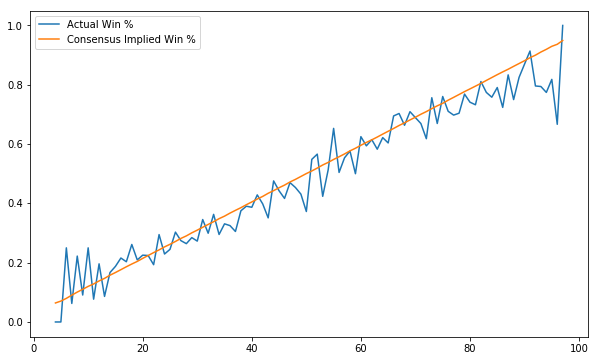

In [84]:
plt.figure(figsize=(10,6))
plt.plot(actual_mean[2:], label='Actual Win %')
plt.plot(consensus_mean[2:], label='Consensus Implied Win %')
plt.legend()
plt.show()

^^^^^^ WHY/HOW IS THIS SO LINEAR

### Regression

In [85]:
# filter for bins with more than 50 games
bin_filter = bin_count[0] > 150

In [86]:
X = consensus_mean[bin_filter].reshape(-1,1)[1:]
y = actual_mean[bin_filter][1:]

In [87]:
lm = LinearRegression().fit(X,y)

In [88]:
lm.coef_

array([ 1.11812273])

In [89]:
lm.intercept_

-0.10061561964796317

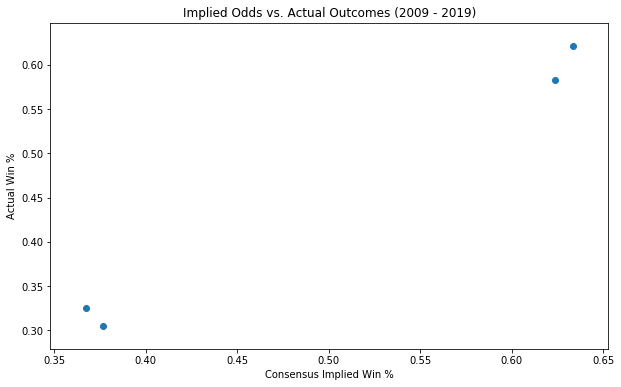

In [90]:
plt.figure(figsize=(10,6))
plt.scatter(X, y)
plt.xlabel('Consensus Implied Win %')
plt.ylabel('Actual Win %')
plt.title('Implied Odds vs. Actual Outcomes (2009 - 2019)')
plt.legend()

### Notes
1. increasing bin filter number increases slope
    - big difference even between 120 and 150
2. changing number of bins does not change coef or intercept materially
3. changing min number of odds does change the intercept materially

### High-Level Backtest

In [91]:
alpha = 0.05

In [92]:
# IDEA - need implied prob to be lower than real prob
data['Consensus_Minus_Alpha'] = data['Average_Probs'] - alpha

In [93]:
filter_signal = data['Max_Implied_Prob'] < data['Consensus_Minus_Alpha']
data['Signal'] = [int(x) for x in filter_signal]

In [94]:
# add payout for each bet if successful
payout = [-100/x if int(x) < 0 else x/100 for x in data['Max_Odds']]
data['Payout_if_Win'] = payout

In [95]:
# add expected value of each bet - this will be numerator of kelly
expectation = [data.iloc[i,43]*data.iloc[i,41]+ (-1)*(1-data.iloc[i,41]) for i in range(len(data))]
data['Expected_Value'] = expectation

In [96]:
# make sure no games where signal = 1 have negative expectation
data.iloc[np.where((data['Signal'] == 1) & (data['Expected_Value'] < 0))[0],:]

,GameID,Date,Teams,Points,Wagers,Opener,Pinnacle,Fivedimes,Bookmaker,BetOnline,...,Average_Probs,Max_Odds,Max_Implied_Prob,Outcome,Home_Away,Bin_Number_Consensus,Consensus_Minus_Alpha,Signal,Payout_if_Win,Expected_Value


In [97]:
# subset where signal = 1 so we put on a position
bets_subset = data.iloc[np.where(data['Signal'] == 1)[0],:]

In [98]:
# calculate our win/loss if we entered all games where signal = 1
bet_outcomes = [bets_subset.iloc[i,43] if bets_subset.iloc[i,38] == 1 
                else -1 
                for i in range(len(bets_subset))]
bets_subset['PnL'] = bet_outcomes

/home/richie10181/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### $1 Bets on each game

In [99]:
print('Number of Bets:',len(bets_subset['PnL']))
print('Number of Wins', sum(bets_subset['Outcome']))
print('Number of Losses:', len(np.where(bets_subset['Outcome']==0)[0]))
print('Average Win/Loss Amount:',np.mean(bets_subset['PnL']))
print('Median Win/Loss Amount:', np.median(bets_subset['PnL']))
print('Standard Deviation:', np.std(bets_subset['PnL']))
print('Sharpe:', np.mean(bets_subset['PnL'])/ np.std(bets_subset['PnL']))
print('Sum Win/Loss:',np.sum(bets_subset['PnL']))

Number of Bets: 433
Number of Wins 237
Number of Losses: 196
Average Win/Loss Amount: 0.2561332124765431
Median Win/Loss Amount: 0.416666666667
Standard Deviation: 1.404967425693719
Sharpe: 0.1823054455159872
Sum Win/Loss: 110.90568100234314


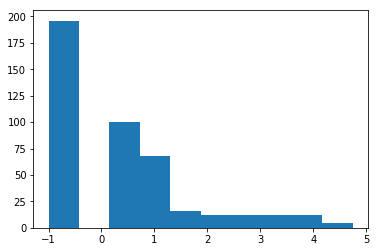

In [100]:
plt.hist(bets_subset['PnL'], bins=10)
plt.show()

In [101]:
dollars_risked = len(bets_subset['PnL'])
net_dollars_received = np.sum(bets_subset['PnL'])
annual_growth = ((dollars_risked + net_dollars_received)/dollars_risked)**(1/10)-1

In [102]:
annual_growth

0.023065806961424684

### Kelly-style bet sizing (assuming $100 portfolio)

In [103]:
kelly = np.array(bets_subset['Expected_Value']) / np.array(bets_subset['Payout_if_Win'])
bets_subset['Kelly'] = kelly

/home/richie10181/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [104]:
kelly_bet_size = np.array(bets_subset['Kelly']) * 100 
kelly_bet_winnings = kelly_bet_size * np.array(bets_subset['Payout_if_Win'])

In [105]:
kelly_pnl = [kelly_bet_winnings[i] if np.array(bets_subset['Outcome'])[i] == 1 
             else -kelly_bet_size[i]
             for i in range(len(bets_subset))]

In [106]:
bets_subset['Kelly_PnL'] = kelly_pnl

/home/richie10181/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [107]:
bets_subset.head()

,GameID,Date,Teams,Points,Wagers,Opener,Pinnacle,Fivedimes,Bookmaker,BetOnline,...,Outcome,Home_Away,Bin_Number_Consensus,Consensus_Minus_Alpha,Signal,Payout_if_Win,Expected_Value,PnL,Kelly,Kelly_PnL
810,7.0,"Sat Nov 17, 2018",Toronto,122,52%,-335,-447,-455,-520,-505,...,1,Away,88,0.783250,1,0.281690,0.003884,0.281690,0.013790,0.388442
979,6.0,"Mon Nov 05, 2018",Utah,111,58%,-103,-158,-145,-170,-160,...,0,Home,64,0.550427,1,0.952381,0.074644,-1.000000,0.078376,-7.837602
1017,2.0,"Tue Feb 06, 2018",New York,89,47%,110,-117,-118,-120,-125,...,0,Home,57,0.490212,1,1.050000,0.004935,-1.000000,0.004700,-0.470028
251,9.0,"Mon Feb 06, 2017",Memphis,89,39%,125,-110,-117,-115,-112,...,1,Home,55,0.473129,1,1.200000,0.040885,1.200000,0.034070,4.088459
541,2.0,"Mon Jan 16, 2017",Milwaukee,98,51%,-280,-415,-420,-365,-175,...,1,Home,81,0.714161,1,0.571429,0.122253,0.571429,0.213942,12.225286


In [108]:
print('Number of Bets:',len(bets_subset['Kelly_PnL']))
print('Number of Wins', sum(bets_subset['Outcome']))
print('Number of Losses:', len(np.where(bets_subset['Outcome']==0)[0]))
print('Average Win/Loss Amount:',np.mean(bets_subset['Kelly_PnL']))
print('Median Win/Loss Amount:', np.median(bets_subset['Kelly_PnL']))
print('Standard Deviation:', np.std(bets_subset['Kelly_PnL']))
print('Sharpe:', np.mean(bets_subset['Kelly_PnL'])/np.std(bets_subset['Kelly_PnL']))
print('Sum Win/Loss:',np.sum(bets_subset['Kelly_PnL']))

Number of Bets: 433
Number of Wins 237
Number of Losses: 196
Average Win/Loss Amount: 3.482024977717799
Median Win/Loss Amount: 0.602609322259
Standard Deviation: 14.5601263132017
Sharpe: 0.23914799245667528
Sum Win/Loss: 1507.716815351807


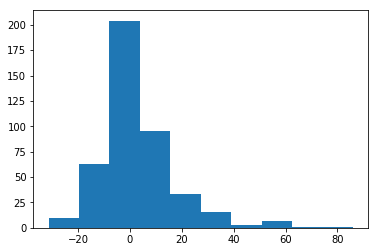

In [109]:
plt.hist(bets_subset['Kelly_PnL'], bins=10)
plt.show()

In [110]:
dollars_risked = sum(kelly_bet_size)
net_dollars_received = np.sum(bets_subset['Kelly_PnL'])
annual_growth = ((dollars_risked + net_dollars_received)/dollars_risked)**(1/10)-1
annual_growth

0.033833224667179085

In [111]:
max(kelly_bet_size)

37.021325745998908

In [112]:
np.where(kelly_bet_size==37.021325745998908)

(array([341]),)

In [113]:
bets_subset.iloc[341,:]

GameID                                 10
Date                     Wed Dec 01, 2010
Teams                                Utah
Points                                109
Wagers                                  -
Opener                                  -
Pinnacle                             -400
Fivedimes                            -360
Bookmaker                            -360
BetOnline                            -130
Bovada                               -400
Heritage                             -400
Intertops                               -
Youwager                             -130
Justbet                              -400
Sportsbetting                        -380
Gtbets                               -400
Sportbet                                -
Nitrogensports                       -400
Betphoenix                              -
Betmania                                -
Skybook                                 -
Mybookie                             -400
Abcislands                        